# CV-to-DV State Transfer (arXiv: 2106.12272)

**Algorithm**: Transfer CV state |ψ⟩ into N qubits

- Input: |ψ⟩_CV ⊗ |0...0⟩_DV  
- Output: |~0⟩_CV ⊗ |Ψ⟩_DV (encoded state)
- Circuit: U = ∏_{k=1}^N W_k V_k

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from numpy import pi, sqrt

# Matplotlib configuration
plt.style.use(['science', 'grid'])
plt.rcParams.update({'font.size': 14, 'text.usetex': True})

# Load CVDV library
from interface import CVDV

-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/luxi/cuda-cvdv/build
[100%] Built target cvdv
Build successful: /home/luxi/cuda-cvdv/build/libcvdv.so

Library compiled successfully!
Library loaded successfully!
Debug logs are written to: /home/luxi/cuda-cvdv/cuda.log
NOTE: Log file is cleared each time CVDV() is instantiated


In [2]:
# Parameters
N = 4           # Number of qubits for encoding
cvQubits = 12   # CV register: 2^12 = 4096 grid points
lam = 0.29      # Interaction parameter (optimal for N=4, Fock |0⟩)
n_fock = 0      # Input Fock state |0⟩

In [3]:
# Initialize: DV register (N qubits) + CV register
# Input: |ψ⟩_CV ⊗ |0...0⟩_DV (per Eq. 1 in paper)
sim = CVDV([N, cvQubits])

sim.setUniform(0)      # DV: |++++>
sim.setCoherent(1, 1)  # CV: |α=1⟩
sim.initStateVector()

sim.info()

Number of registers: 2
Total state size: 65536 elements (0.001 GB in VRAM)
  Register 0: dim=16, qubits=4, dx=0.626657, x_bound=10.026513
  Register 1: dim=4096, qubits=12, dx=0.039166, x_bound=160.424210
Initialized state with 2 registers, total size: 65536


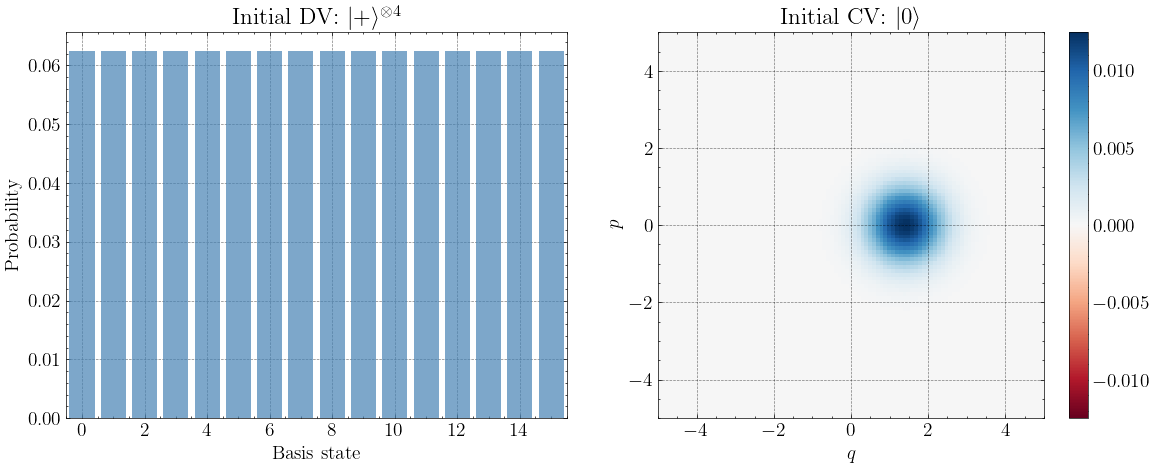

In [4]:
# Initial state: DV bar + CV Wigner side by side
probs_dv = sim.measure(0)
wigner_cv = sim.getWignerFullMode(1, wignerN=101, wXMax=5, wPMax=5)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# DV state (bar chart)
axes[0].bar(range(len(probs_dv)), probs_dv, color='steelblue', alpha=0.7)
axes[0].set_xlabel(r'Basis state')
axes[0].set_ylabel(r'Probability')
axes[0].set_title(r'Initial DV: $|+\rangle^{\otimes %d}$' % N)
axes[0].set_xlim(-0.5, 15.5)

# CV state (Wigner plot)
vmax = np.max(np.abs(wigner_cv))
im = axes[1].imshow(wigner_cv, extent=[-5, 5, -5, 5], origin='lower',
                     cmap='RdBu', vmin=-vmax, vmax=vmax, aspect='equal')
axes[1].set_xlabel(r'$q$')
axes[1].set_ylabel(r'$p$')
axes[1].set_title(r'Initial CV: $|%d\rangle$' % n_fock)
plt.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()

In [5]:
dvReg = 0  # DV register index
cvReg = 1  # CV register index

for k in range(1, N+1):
    qubitIdx = k - 1  # 0-indexed qubit within DV register
    
    # V_k: exp(i·v_k·q·σ_y) => exp(-i·v_k·q·σ_y)
    v_k = -pi / (2 * lam * (1 << k))
    sim.pauliRotation(dvReg, qubitIdx, 0, pi/2)
    sim.cd(cvReg, dvReg, qubitIdx, 1j * v_k / sqrt(2))
    sim.pauliRotation(dvReg, qubitIdx, 0, -pi/2)
    
    # W_k: exp(i·w_k·p·σ_x) => exp(i·w_k·p·σ_z)
    w_k = lam * (1 << k) / 2 * (-1 if k == N else 1)
    sim.cd(cvReg, dvReg, qubitIdx, -w_k / sqrt(2))

print(f"Encoding complete: applied {N} layers of V_k W_k")

Encoding complete: applied 4 layers of V_k W_k


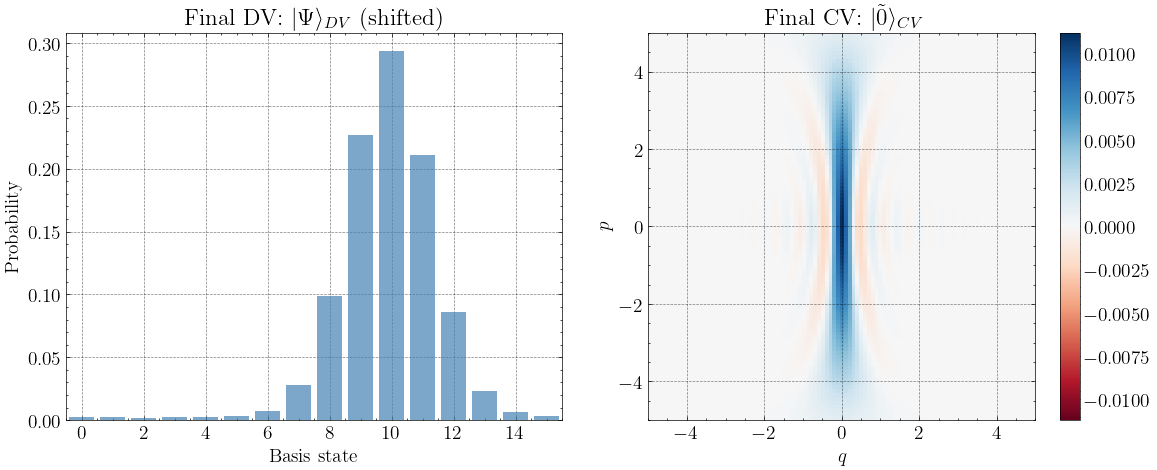

In [8]:
# Final state: DV bar + CV Wigner side by side
probs_dv = sim.measure(0)
wigner_cv = sim.getWignerFullMode(1, wignerN=101, wXMax=5, wPMax=5)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Compute shifted index mapping: bit reverse, swap halves, reverse
indices = np.arange(len(probs_dv))
rev_indices = sum((indices >> i & 1) << (N - 1 - i) for i in range(N))
shifted_idx = np.roll(rev_indices, len(probs_dv) // 2)[::-1]

# DV state (bar chart) - use shifted indices directly
axes[0].bar(range(len(probs_dv)), probs_dv[shifted_idx], color='steelblue', alpha=0.7)
axes[0].set_xlabel(r'Basis state')
axes[0].set_ylabel(r'Probability')
axes[0].set_title(r'Final DV: $|\Psi\rangle_{DV}$ (shifted)')
axes[0].set_xlim(-0.5, 15.5)

# CV state (Wigner plot)
vmax = np.max(np.abs(wigner_cv))
im = axes[1].imshow(wigner_cv, extent=[-5, 5, -5, 5], origin='lower',
                     cmap='RdBu', vmin=-vmax, vmax=vmax, aspect='equal')
axes[1].set_xlabel(r'$q$')
axes[1].set_ylabel(r'$p$')
axes[1].set_title(r'Final CV: $|\tilde{0}\rangle_{CV}$')
plt.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()